In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
os.chdir("../CPSL_TI_Radar")
from CPSL_TI_Radar.ConfigManager import ConfigManager

#specify the configuration path
config_folder_path = "/home/david/CPSL_TI_Radar/configurations"
config_file = "DCA1000/custom_configs/ISAR_mocap.cfg"

path = os.path.join(config_folder_path,config_file)

#initialize the config manager
config_manager = ConfigManager()
config_manager.load_config_from_cfg(path)
config_manager.compute_radar_perforance()

In [11]:
#number of rx channels
rx_channels = config_manager.radar_performance["angle"]["num_rx_antennas"]

#samples per chirp
samples_per_chirp = int(config_manager.radar_config["profileCfg"]["adcSamples"])

#chirps per frame
chirp_start_profile_idx = int(config_manager.radar_config["frameCfg"]["startIndex"])
chirp_end_profile_idx = int(config_manager.radar_config["frameCfg"]["endIndex"])
chirps_per_loop = chirp_end_profile_idx - chirp_start_profile_idx + 1
chirp_loops_per_frame = int(config_manager.radar_config["frameCfg"]["loops"])
chirps_per_frame = chirp_loops_per_frame * chirps_per_loop

print("rx_channels:{}\nsamples_per_chirp:{}\nchirps per frame:{}\n".format(
    rx_channels,
    samples_per_chirp,
    chirps_per_frame
))

# compute range bins
range_res = config_manager.radar_performance["range"]["range_res"]
range_bins = np.arange(0, samples_per_chirp) * range_res

# compute doppler bins
vel_res = config_manager.radar_performance["velocity"]["vel_res"]
vel_max = config_manager.radar_performance["velocity"]["vel_max"]
num_vel_bins = int(config_manager.radar_performance["velocity"]["num_doppler_bins"])
velocity_bins = np.arange(-1 * vel_max, vel_max - vel_res, vel_res)

rx_channels:4
samples_per_chirp:80
chirps per frame:250



In [12]:
#load an adc_data file
adc_file_path = "/home/david/Downloads/adc_data.bin"
data = np.fromfile(adc_file_path,dtype=np.int16)

#convert the data into real and complex
data = data.reshape(2,-1)

#obtain the complex numbers
data = data[0] + 1j * data[1]

#indexed by [frame,rx channel, sample, chirp]
adc_data_cube = data.reshape(-1,rx_channels,samples_per_chirp,chirps_per_frame)
print(adc_data_cube.shape)

(10, 4, 80, 250)


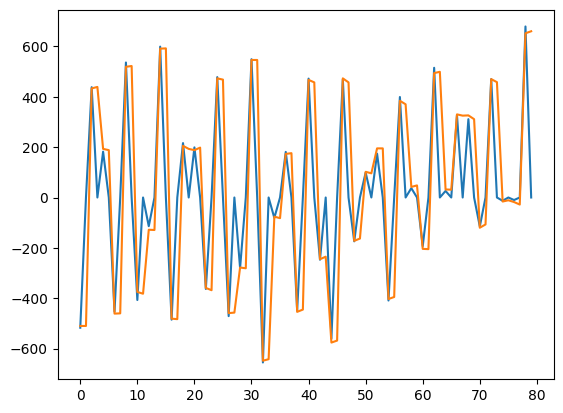

In [13]:
#plot the adc samples

frame = 0
chirp = 0
rx_antenna = 0

samples = adc_data_cube[frame,rx_antenna,:,chirp]

plt.plot(np.real(samples))
plt.plot(np.imag(samples))

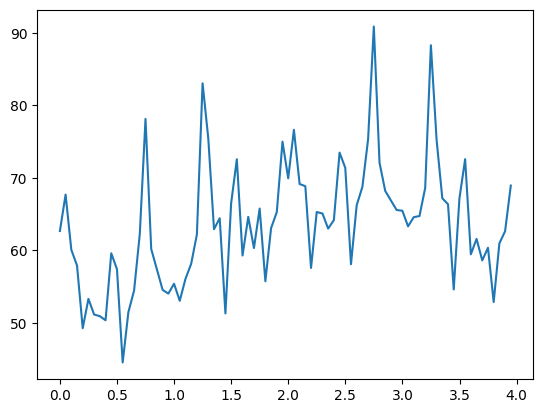

In [14]:
# plot the range FFT
frame = 0
chirp = 0
rx_antenna = 0

samples = adc_data_cube[frame,rx_antenna,:,chirp]

data = 20* np.abs(np.log10(np.fft.fftshift(np.fft.fft(samples, axis=0))))

plt.plot(range_bins,data)

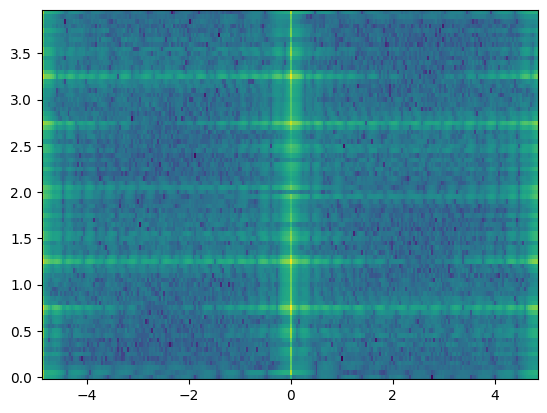

In [23]:
# plot the range Doppler plot
frame = 0
rx_antenna = 0

samples = adc_data_cube[frame,rx_antenna,:,:]

# compute range FFT
data = np.fft.fftshift(np.fft.fft(samples, axis=0))

# compute doppler FFT
data = 20 * np.log10(np.abs(np.fft.fftshift(np.fft.fft(data, axis=1))))


#compute the range and doppler bins
vels,rngs = np.meshgrid(velocity_bins,range_bins)

plt.pcolormesh(vels,rngs,data)